# Table of Contents
* [Discrimination (2) -- Discrimination bayésienne](#Discrimination-%282%29----Discrimination-bayésienne)
	* [Principe général](#Principe-général)
	* [Analyse discriminante linéaire](#Analyse-discriminante-linéaire)
		* [Principe de la méthode](#Principe-de-la-méthode)
		* [Exemple avec des données bivariées](#Exemple-avec-des-données-bivariées)
		* [Autre exemple](#Autre-exemple)
		* [Un exercice](#Un-exercice)
		* [Pourquoi l'analyse discriminante ?](#Pourquoi-l'analyse-discriminante-?)
		* [Mais au fait, et la régression logistique ?](#Mais-au-fait,-et-la-régression-logistique-?)
	* [Analyse discriminante quadratique](#Analyse-discriminante-quadratique)
		* [Principe](#Principe)
		* [Exemple: mélange de gaussiennes de covariances différentes](#Exemple:-mélange-de-gaussiennes-de-covariances-différentes)
		* [Expression des probas d'appartenance aux différentes classes](#Expression-des-probas-d'appartenance-aux-différentes-classes)
	* [Naive Bayes](#Naive-Bayes)
		* [Principe](#Principe)
		* [Exemple 1 - mélange de gaussiennes](#Exemple-1---mélange-de-gaussiennes)
		* [Exemple 2 - Discrimination de digits binaires](#Exemple-2---Discrimination-de-digits-binaires)


In [1]:
%run nbinit.ipy

... Configuring matplotlib formats
... Configuring matplotlib with inline figures
... Importing numpy as np, scipy as sp, pyplot as plt, scipy.stats as stats
   ... scipy.signal as sig
... Importing widgets, display, HTML, Image, Javascript
... Some LaTeX definitions


... Defining figures captions 


... Loading customized Javascript for interactive solutions (show/hide)
... Redefining interactive from ipywidgets


# Discrimination bayésienne

## Principe général

$\def\Pr#1{\text{Pr}\left\{#1\right\}}$

Dans le chapitre 4, nous avons présenté une première méthode de classification, la régression logistique. Celle-ci repose, de manière un peu magique, sur l'hypothèse selon laquelle le log-rapport de vraisemblance est une fonction linéaire des variables explicatives. Nous allons présenter une autre approche, qui part d'un point de vue différent. 

L'idée est de modéliser également la distribution des variables explicatives $X$, pour chacune des classes, et d'utiliser la formule de Bayes pour revenir à la probabilité qui nous intéresse, à savoir $\Pr{Y|X}$. Lorsqu'on utilise des distributions gaussiennes pour $X$, on arrive aux méthodes connues comme LDA (*Linear Discriminant Analysis*) et QDA (*Quadratic Discriminant Analysis*). L'approche est cependant très générale et n'est pas limitée au cas gaussien. Nous verrons en particulier que la méthode dite "*Naïve*" implantée dans `sklearn` permet d'utiliser d'autres modèles. 

On note $Y$ une variable aléatoire qui prend ses valeurs sur un ensemble fini, les labels des classes. A la différence de ce qu'on avait fait avec la régression logistique, les variables explicatives $X$ seront également probabilisées, éventuellement il s'agira d'ailleurs de vecteurs aléatoires. 

Les méthodes de discrimination bayésienne reposent, bien évidemment, sur l'utilisation de la règle de Bayes. Celle-ci est rappelée ci-dessous :
\begin{equation}
\Pr{Y=k|X=x} = \frac{ \Pr{X=x|Y=k}.\Pr{Y=k}  }{\Pr{X=x}},
\label{eq:bayesrule1}
\end{equation}

ce qui se lit de la manière suivante :  la probabilité que la classe soit $k$, si on a observé des variables $x$, est donnée par  le produit entre la probabilité de la classe $k$ et la probabilité d'observer cet $x$ si la classe est effectivement $k$. Le tout est ensuite normalisé. \footnote{Vous vérifierez aisément que $\Pr{X=x}=\sum_n \Pr{X=x|Y=n}.\Pr{Y=n} $  est bien le facteur de normalisation à utiliser pour que $\Pr{Y=k|X=x}$ soit effectivement une probabilité.}

Pour la présentation, nous allons reprendre des notations classiques, qui sont notamment celles employées par [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/). \footnote{Notons une toute petite subtilité.  Si $X$ est gaussien, bien entendu la proba $\Pr{X=x[Y=k}$ est nulle, et il faut en fait introduire la densité de probabilité $f_k(x)$ comme la limite si $\Delta x \rightarrow 0$ de $\Pr{X\in[x-\Delta x/2,x+\Delta x/2]|Y=k}$. Dans ce cas, $\Pr{X\in[x-\Delta x/2,x+\Delta x/2]|Y=k}\simeq f_k(x) \Delta x$, et on voit que les $\Delta_x$ se simplifient dans l'expression (\ref{eq:bayesrule1} ).}

La probabilité des différentes classes étant donné les observations $x$, peut être  écrite comme 
\begin{equation}
\Pr{Y=k|X=x} = \frac{ \pi_k f_k(x) }{\sum_{l=1}^L \pi_l f_l(x)},
\label{eq:bayesrule2}
\end{equation}
avec 

- $f_k(x)=\Pr{X=x[Y=k}$ la densité de $X$ dans la classe $k$,
- $\pi_k=\Pr{Y=k}$ est la probabilité *a priori* pour la classe $k$.

Ceci étant donné, que nous faut-il faire pour estimer ces probabilités ? 

Clairement, il faut que nous déterminions l'ensemble des densités $f_k(x)$, ainsi que les poids $\pi_k$. Pour ce qui est des poids, c'est immédiatement les proportions observées dans les données $y$ de la base d'apprentissage. Pour le reste, on voit bien que quelque part il faut se donner une forme paramétrique de $f(x)$ (ou au moins une manière de calculer $f(x)$ pour tout $x$, c'est le cas des estimateurs à noyau). 

## Analyse discriminante linéaire

Avant de poursuivre, on va examiner un petit exemple de mélange gaussien. Les données sont gaussiennes, seule la moyenne diffère selon la classe. On utilise la classe `LDA` que l'on trouve comme de coutume, chez `sklearn`. Le schéma étant toujours le même, on instancie, on apprend (*fit*), on prédit. Sans avoir encore présenté la méthode en tant que tel, on observe que la méthode rend un seuil de discrimination, qui sépare les deux histogrammes (ce qui paraît parfaitement naturel) et que ce seuil se déplace lorsqu'on fait varier les proportions des deux classes par le paramètre de mélange `pi1`. 

In [2]:
# L'histogramme standard ne permet pas de normalisation à une valeur quelconque
# ce qui est nécessaire si on veut intégrer des proportions. D'où cette version rapide. 

def myhist(x, bins=50, normed=None, color="blue", **kwargs):
    # bins peut être un vecteur des positions (gauches) des intervalles
    if isinstance(bins, int): bins = np.linspace(x.min(), x.max(), bins)
    width = bins[2] - bins[1]
    c, b = np.histogram(x, bins=bins)

    f = normed / (width * np.size(x)) if isinstance(normed,
                                                    (int, float)) else 1
    plt.bar(b[:-1], f * c, width=width, color=color, **kwargs)


#### Test
#bins=np.linspace(-6,6,50)
#myhist(X[0:N1], bins, normed=None)

In [3]:
import warnings
warnings.filterwarnings("ignore")#("ignore")

/usr/local/lib/python3.5/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


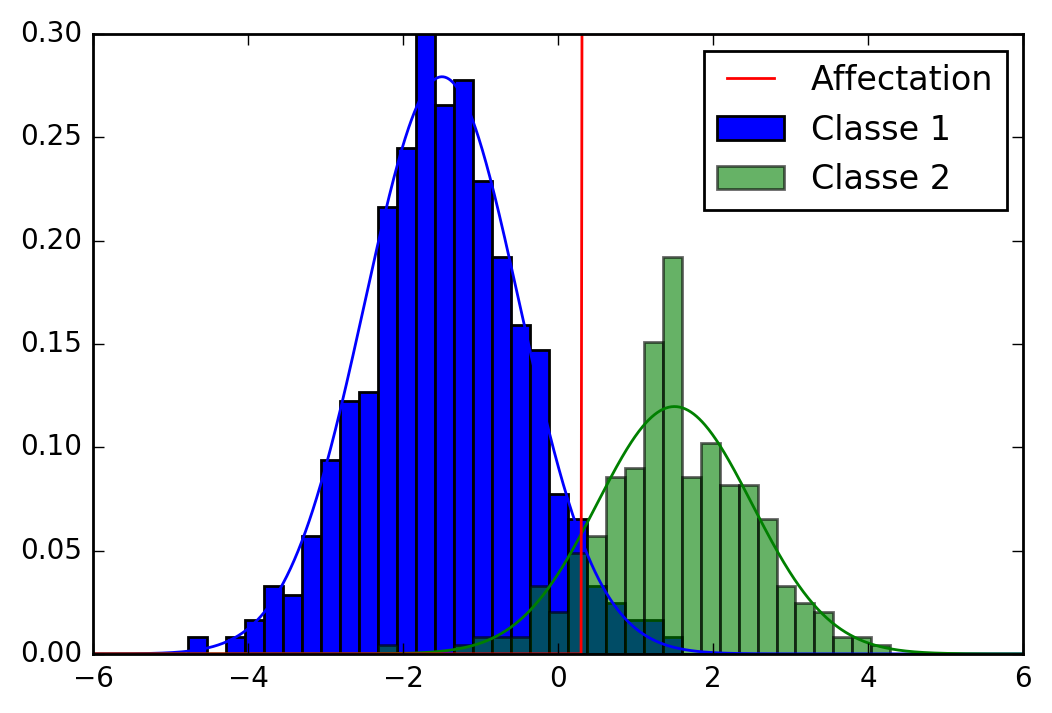

In [4]:
import numpy as np
from sklearn.lda import LDA

# Deux gaussiennes
c1 = stats.norm(loc=-1.5, scale=1)
c2 = stats.norm(loc=1.5, scale=1)

pi1 = 0.7
pi2 = 1 - pi1
N = 1000  # Nombre d'exemples
N1 = np.ceil(N * pi1)
X = np.concatenate((c1.rvs(size=N1), c2.rvs(size=N - N1)))
N = np.size(X)
X = np.reshape(X, (N, 1))
y = np.zeros(N)
y[N1:N] = 1

# instanciation du classifieur
clf = LDA()
# On apprend les choses (fit) sur la base totale -- pas de test ici
clf.fit(X, y)

# On trace  la frontière "à la main" en calculant les prédictions 
# pour tous les x
x = np.linspace(-6, 6, 1000)
xp = clf.predict(np.reshape(x, (len(x), 1)))

#**Tracé des résultats *** 
plt.plot(x, pi1 * c1.pdf(x))  # tracé de la pdf classe 1
plt.plot(x, pi2 * c2.pdf(x))
ymin, ymax = plt.ylim()  #on récupère les limites courantes
#
bins = np.linspace(-6, 6, 50)
myhist(X[0:N1], bins=bins, normed=pi1, color="blue", label="Classe 1")
myhist(
    X[N1:N],
    bins=bins,
    normed=1 - pi1,
    color="green",
    alpha=0.6,
    label="Classe 2")

plt.plot(x, ymax * xp, label="Affectation")
plt.ylim((ymin, ymax))
_ = plt.legend()
figcaption(
    "Histogrammes des deux classes (avec proportions différentes), le seuil est décalé."
)

### Principe de la méthode

On part donc avec les hypothèses suivantes :

- on a $L$ classes,
- les $x$ sont gaussiens dans chaque classe, **et de même matrice de covariance** (ou variance dans le cas 1D),



Dans le cas monodimensionnel, la densité gaussienne est
$$
f_k(x)= \frac{1}{\sqrt{2\pi}\sigma_k} 
e^{-\frac{1}{2} \frac{\left(x-\mu_k\right)^2}{\sigma_k^2}  }
$$
avec $\mu_k$ la moyenne et $\sigma^2=\sigma_k^2$ la variance. En injectant cette formule dans la règle de Bayes (\ref{eq:bayesrule2}), on obtient un (assez) gros truc :
$$
\Pr{Y=k|X=x} = \frac{\pi_k \frac{1}{\sqrt{2\pi}\sigma} 
e^{-\frac{1}{2} \frac{\left(x-\mu_k\right)^2}{\sigma^2}  }} 
{\sum_{l=1}^L \pi_l \frac{1}{\sqrt{2\pi}\sigma} 
e^{-\frac{1}{2} \frac{\left(x-\mu_l\right)^2}{\sigma^2}  }}
$$
Bien entendu, on voit que certains facteurs  se simplfient. Ensuite, il faut se souvenir que finalement, pour décider de l'affectation à une classe, il suffit de retenir la classe de proba la plus élevée. Comme les expressions de toutes ces probas font intervenir le même dénominateur, on peut s'en passer et ne comparer que les numérateurs. Si on compare justement deux de ces numérateurs, disons pour les classes $k$ et $m$, on obtient ceci :
$$
\pi_k e^{-\frac{1}{2} \frac{\left(x-\mu_k\right)^2}{\sigma^2}  }
\overset{k}{\underset{m}{\gtrless}}
\pi_m e^{-\frac{1}{2} \frac{\left(x-\mu_m\right)^2}{\sigma^2}  }.  
$$
Il est aisé de voir que les termes quadratiques se simplifient dans la comparaison. En prenant le logarithme de la fonction résultante, on arrive à ce qu'on appelle le *score de discrimination* (*discriminant score*) :
$$
\delta_k(x)=\phi_k(x) = x.\frac{\mu_k}{\sigma^2}-\frac{\mu_k^2}{2\sigma^2}+\log \pi_k.
$$
On note bien entendu qu'il s'agit d'une **fonction linéaire en $x$**, d'où le nom...
Lorsque l'on compare deux de ces fonctions discriminantes, on obtient aisément qu'il suffit en fait de comparer $x$ à un seuil :
$$
x \overset{k}{\underset{m}{\gtrless}} \frac{\mu_k+\mu_l}{2} - \frac{\sigma^2}{\mu_k-\mu_l}\log\left(\frac{\pi_k}{\pi_l}\right),
$$
qui se réduit, comme il se doit,  à la demi-somme des moyennes dans le cas de proportions identiques des deux classes ($\pi_k=\pi_m$). 

Wonderful. Et comment fait-on en pratique ? Et bien ce n'est pas bien compliqué. Comme on l'a compris, finalement ce qu'il nous faut c'est les valeurs des $\pi_k$, des moyennes $\mu_k$ et de $\sigma^2$. Puisqu'on dispose d'une base d'apprentissage c'est très simple d'estimer ces valeurs : si $n_k$ désigne le nombre d'exemples de la classe $k$, alors

- $\hat\pi_k = \frac{n_k}{N}$
- $\displaystyle{\hat\mu_k = \frac{1}{n_k} \sum_{n/ y_n=k} x_n}$ estimée classique de la moyenne, la somme porte sur les $x_n$ appartenant à la classe $k$
- $\displaystyle{\hat\sigma^2_k = \frac{1}{n_k-1} \sum_{n/ y_n=k} (x_n-\mu_k)^2}$ estimée de $\sigma^2$ dans la classe k
- $\displaystyle{\hat\sigma^2 = \frac{1}{N-L} \sum_{k=1}^L (n_k-1)\hat\sigma_k^2}$,  moyenne des $\sigma_k^2$ estimés sur chaques classes. 



Bien entendu, tout celà s'étend au-delà du cas monodimensionnel. En général on n'a pas qu'une seule variable explicative, mais plusieurs (parmi lesquelles il faudra trier, mais c'est une autre histoire). ce n'est pas vraiment plus compliqué. Simplement il faut maintenenant partir avec une gaussienne multivariée, de dimension $p$, qui a la forme
$$
f_k(x)= \frac{1}{(2\pi)^{p/2}\text{det}(\Gamma)^{1/2}} e^{-\frac{1}{2} (x-\mu_k)^T\Gamma^{-1}(x-\mu_k)}.
$$
La moyenne $\mu_k$ est un vecteur qui contient les moyennes de toutes les composantes de $x$. La matrice $\Gamma$ est la matrice de covariance de $x$, et comprend toutes les variances et covariances intercomposantes. 

In [5]:
# For 3D representations
from mpl_toolkits.mplot3d.axes3d import Axes3D


def mesh(obj3D, X=None, Y=None, numfig=None, subplt=(1, 1, 1), cmap='hot'):
    """
    Emulates Matlab's mesh 
    Author: jfb
    """
    fig = plt.figure(numfig)
    ax = fig.add_subplot(subplt[0], subplt[1], subplt[2], projection='3d')
    m, n = np.shape(obj3D)
    Z = obj3D
    if (X is None) or (Y is None):
        mm = np.arange(m)
        nn = np.arange(n)
        X, Y = np.meshgrid(nn, mm)
    ax.plot_surface(
        X,
        Y,
        obj3D,
        rstride=max([round(m / 50), 1]),
        cstride=max([round(n / 50), 1]),
        cmap=cmap)
    cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir='x', offset=-4, cmap=cm.coolwarm)
    cset = ax.contour(X, Y, Z, zdir='y', offset=4, cmap=cm.coolwarm)

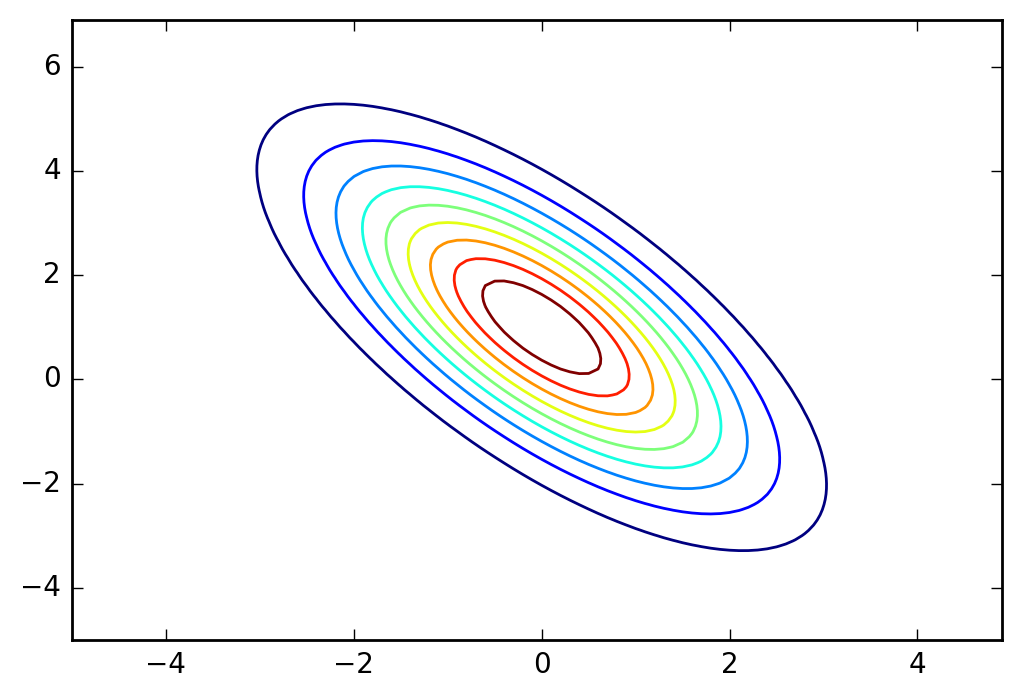

In [6]:
# On crée une gaussienne multivariable ici 
c1=stats.multivariate_normal(mean=[0,1], cov=[[2, -1],[-2, 4]])

# On prépare de quoi la représenter en 3D
x, y = np.mgrid[-5:5:.1, -5:7:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

# Avec des contours
%matplotlib inline
plt.contour(x,y,c1.pdf(pos),10)
_=plt.xlabel("")

Pour effectuer la discrimination entre deux classes, il faut reprendre exactement les mêmes étapes que précédemment. On aboutit alors à la fonction de discrimination suivante :
$$
\delta(k) = x^T\Gamma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Gamma^{-1}\mu_k+\log\pi_k.
\label{eq:fonctiondicriminanteLDA}
$$
La surface séparatrice est l'ensemble des points qui forment la frontière entre deux classes, par exemple $k$ et $m$. En prenant ainsi $\delta_k=\delta_m$, il vient
$$
x^T\Gamma^{-1}(\mu_k-\mu_m) - \frac{1}{2}\left(\mu_k^T\Gamma\mu_k - \mu_m^T\Gamma\mu_m\right)+\log\pi_k-\log\pi_m=0.
\label{eq:separatriceLDA}
$$
Il s'agit encore d'une fonction linéaire en $x$ ; un hyperplan. 

En pratique, il faudra à nouveau estimer les paramètres des différentes densités. les formules non analogues, si ce n'est que l'estimation de la matrice de covariance globale est donnée par
$$
\hat\Gamma = \frac{1}{N-L} \sum_{k=1}^L \sum_{n/ y_n=k} (x_n-\mu_k)(x_n-\mu_k)^T.
$$

### Exemple avec des données bivariées

Illustrons ceci avec des données bidimensionnelles. Somme de deux gaussiennes, de moyennes différentes, mais de même matrice de covariance. 


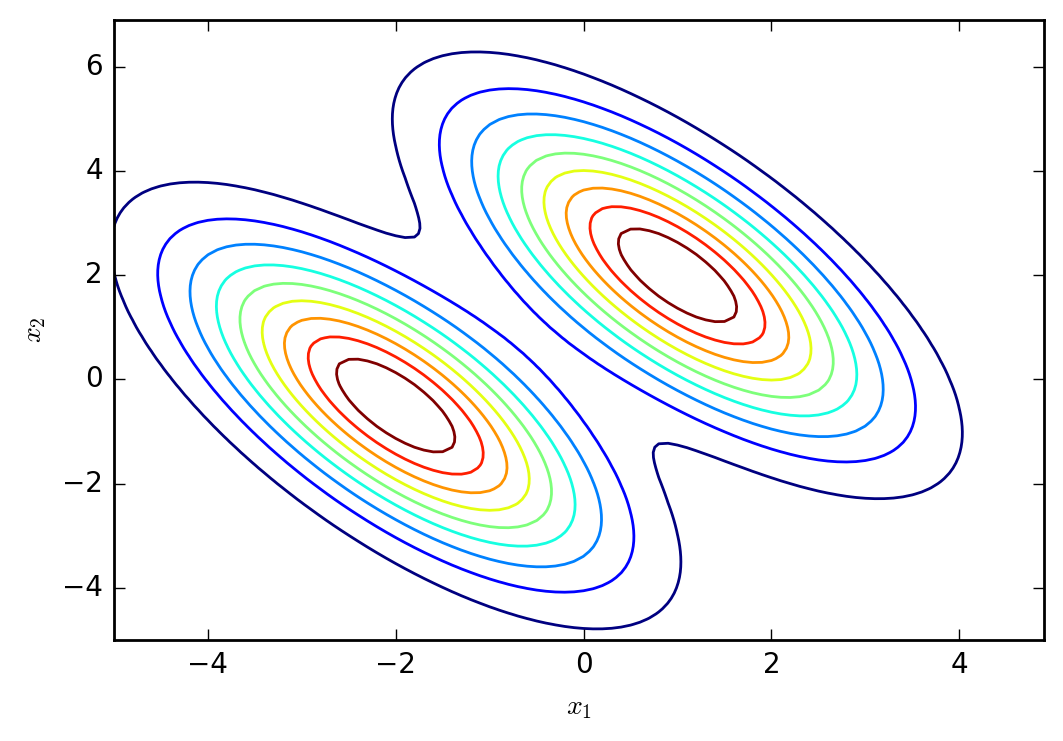

In [7]:
c1=stats.multivariate_normal(mean=[1.,2], cov=[[2, -1],[-2, 4]])
c2=stats.multivariate_normal(mean=[-2,-0.5], cov=[[2, -1],[-2, 4]])


# On prépare de quoi la représenter en 3D
x, y = np.mgrid[-5:5:.1, -5:7:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

# Avec des contours
%matplotlib inline
plt.contour(x,y,c1.pdf(pos)+c2.pdf(pos),10)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
figcaption("Représentation contour pour un mélande de deux gaussiennes 2D")

Générons des données... On trace ensuite à la fois le nuage de points, et les histogrammes des deux classes, projeté sur chacun des axes, c'est-à-dire ce que l'on obtient si on ne considère que l'une des deux dimensions. Il apparaît clairement qu'il serait très difficile de faire une classification correcte en introduisant un simple seuil sur les données monodimensionnelles. Par contre, avec les données bi-dimensionnelles, la LDA conduit à un très bon score. 

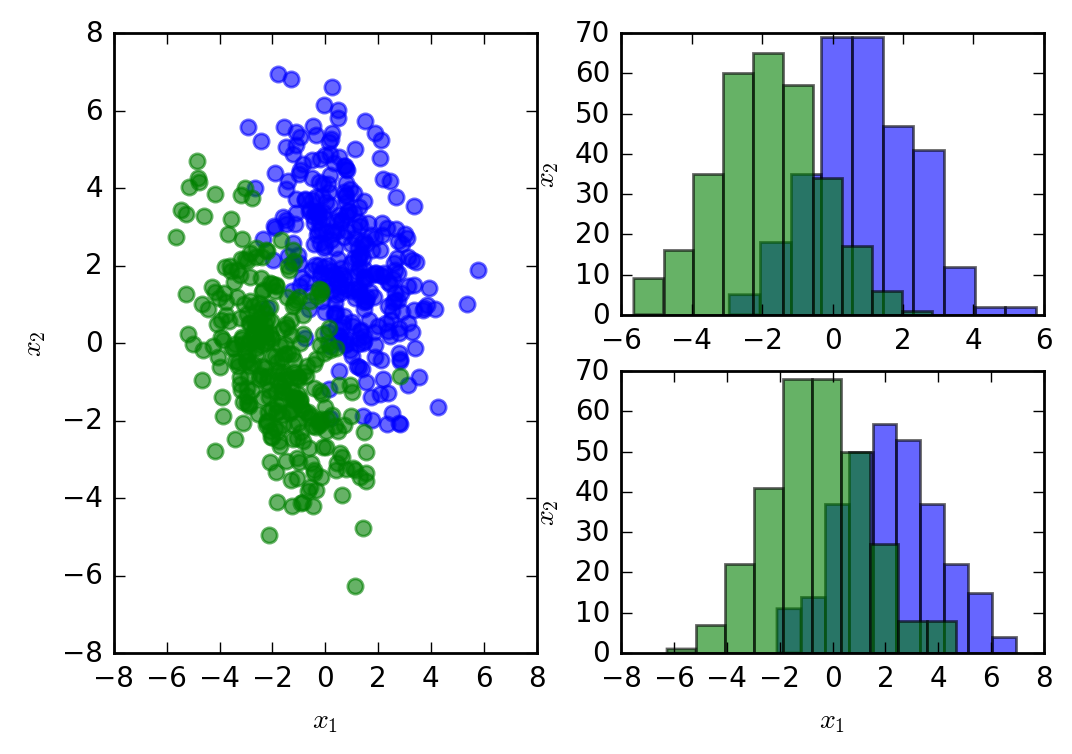

In [8]:
c1rvs = c1.rvs(size=300)  #composantes dans la classe 1
c2rvs = c2.rvs(size=300)
plt.subplot2grid((2, 2), (0, 0), rowspan=2)
#
x1_1 = c1rvs[:, 0]  #x1 dans la classe 1
x2_1 = c1rvs[:, 1]  #x2 dans la classe 1
x1_2 = c2rvs[:, 0]  #x1 dans la classe 2
x2_2 = c2rvs[:, 1]  #x2 dans la classe 2
#
plt.scatter(x1_1, x2_1, marker='o', s=30, color='blue', alpha=0.6)
plt.scatter(x1_2, x2_2, s=30, color='green', alpha=0.6)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.subplot2grid((2, 2), (0, 1), rowspan=1)
plt.hist(x1_1, color='blue', alpha=0.6)
plt.hist(x1_2, color='green', alpha=0.6)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.subplot2grid((2, 2), (1, 1), rowspan=1)
plt.hist(x2_1, color='blue', alpha=0.6)
_ = plt.hist(x2_2, color='green', alpha=0.6)
_ = plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
figcaption("Mélange de deux gaussiennes de mêmes matrices de covariance")

In [9]:
X = np.concatenate((c1rvs, c2rvs))
y = np.ones(np.shape(X)[0])
y[np.shape(c1rvs)[0]::] = 2

# instanciation du classifieur
clf2D = LDA()
# On apprend les choses (fit) sur la base totale -- pas de test ici
_ = clf2D.fit(X, y)

# On trace  la frontière "à la main" en calculant les prédictions pour tous les x
#xp=clf.predict(np.reshape(x,(len(x),1))) 
#x=np.linspace(-6,6,1000)

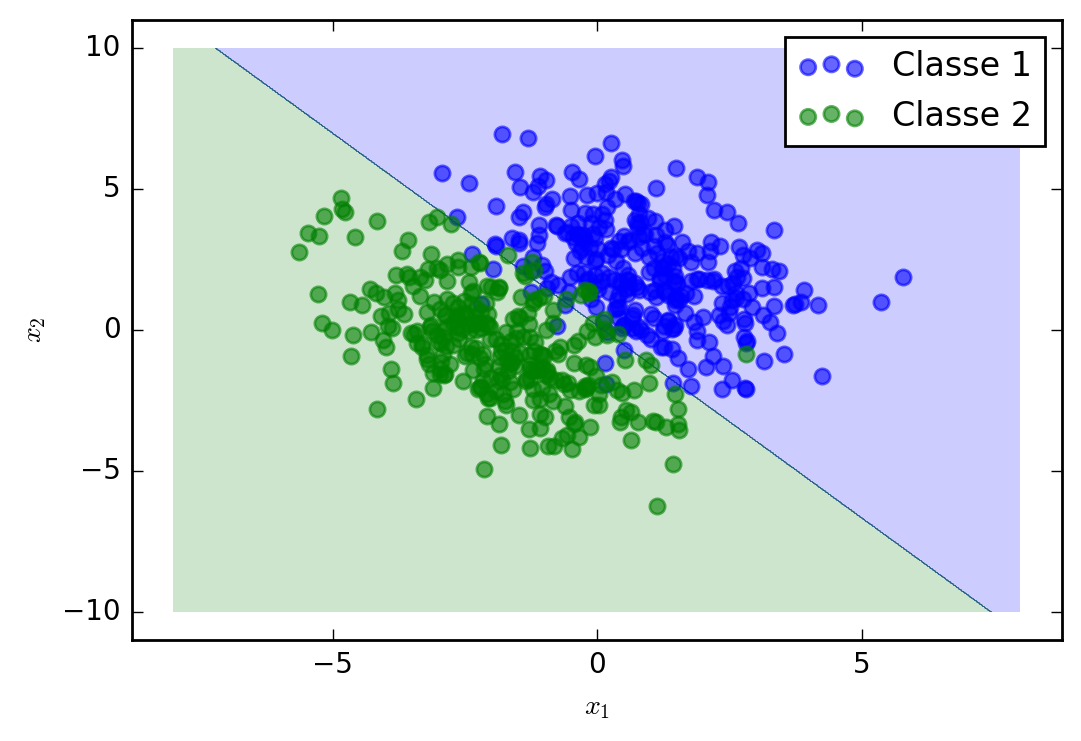

In [10]:
x_min, x_max = -8, 8
y_min, y_max = -10, 10

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf2D.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, colors=("blue", "green"), alpha=.2)
plt.scatter(
    x1_1, x2_1, marker='o', s=30, color='blue', alpha=0.6, label="Classe 1")
plt.scatter(x1_2, x2_2, s=30, color='green', alpha=0.6, label="Classe 2")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
figcaption(
    "Discrimination bayésienne linéaire -- Surface séparatrice et discrimination"
)

Pour calculer un score sur une base de test, comme il s'agit de données simulées, il suffit de se donner quelques données supplémentaires. Sinon, comme d'habitude, il faudrait scinder la base globale en une base d'apprentissage et une base de test. 

In [11]:
from mycfm import *
c1_test = c1.rvs(size=300)
c2_test = c2.rvs(size=300)
X = np.concatenate((c1_test, c2_test))
y_test = np.ones(np.shape(X)[0])
y_test[np.shape(c1_test)[0]::] = 2
#
y_pred = clf2D.predict(X)
mycfm(y_test, y_pred)

Predicted  1.0  2.0  All
True                    
1.0        289   11  300
2.0          5  295  300
All        294  306  600

Score          0.973
Precision      0.964
Recall         0.983


Comme on le constate, ça va. Mais bien entendu, on est dans des conditions particulièrement favorables. Les hypothèses sont parfaitement respectées (données gaussiennes, covariances parfaitement identiques, bonne séparation des deux nuages). 

### Autre exemple

Une autre pour le plaisir. 

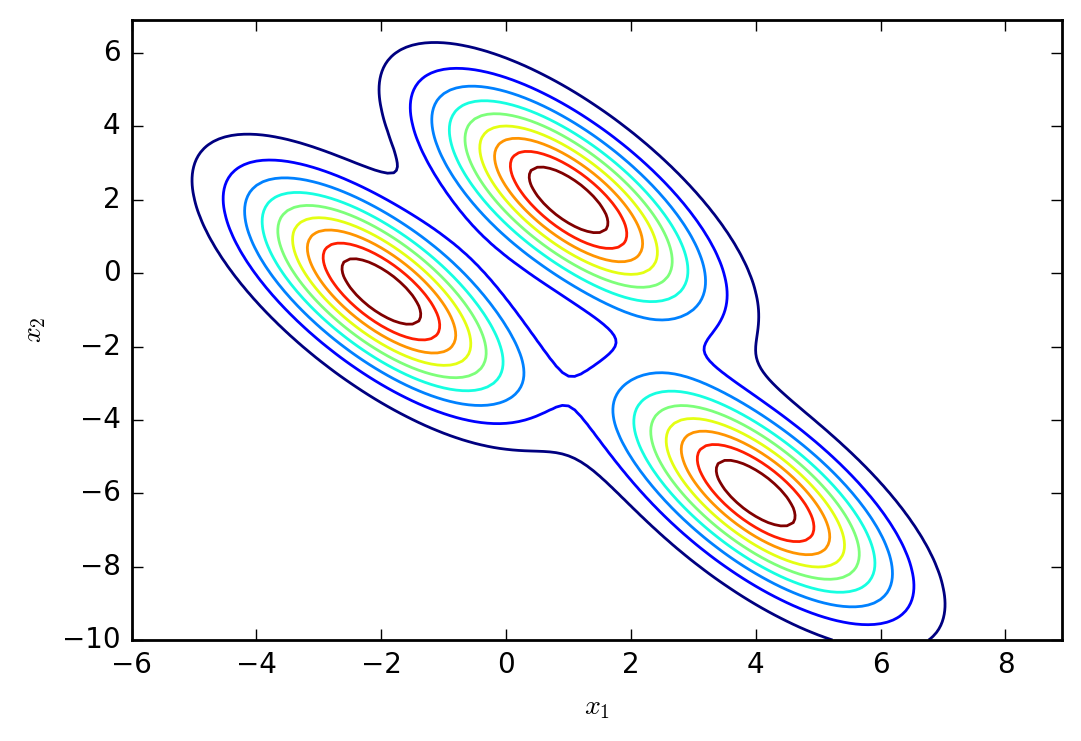

In [12]:
c1 = stats.multivariate_normal(mean=[1., 2], cov=[[2, -1], [-2, 4]])
c2 = stats.multivariate_normal(mean=[-2, -0.5], cov=[[2, -1], [-2, 4]])
c3 = stats.multivariate_normal(mean=[4, -6], cov=[[2, -1], [-2, 4]])

# On prépare de quoi la représenter en 3D
x, y = np.mgrid[-6:9:.1, -10:7:.1]
pos = np.empty(x.shape + (2, ))
pos[:, :, 0] = x
pos[:, :, 1] = y

# Avec des contours
%matplotlib inline
plt.contour(x, y, c1.pdf(pos) + c2.pdf(pos) + c3.pdf(pos), 10)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
figcaption(
    "Le masque africain -- mélange de 3 gaussiennes 2D de mêmes covariances")

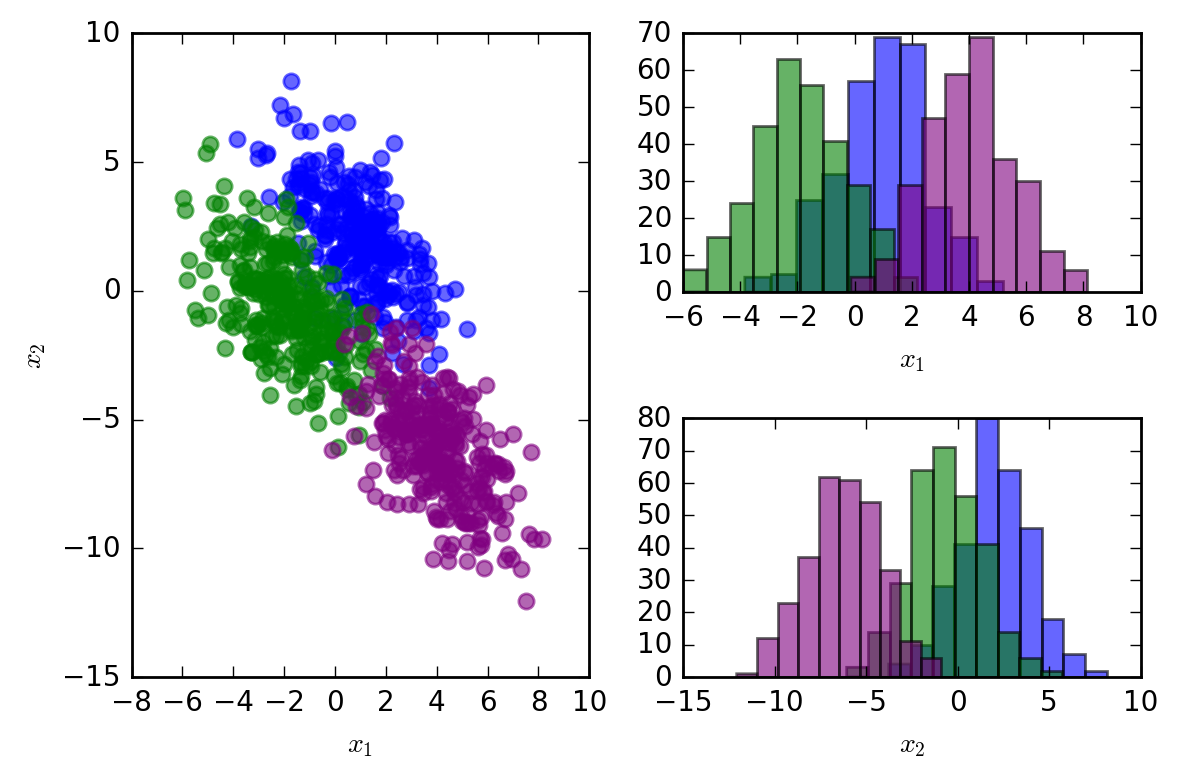

In [13]:
xx1 = c1.rvs(size=300)
xx2 = c2.rvs(size=300)
xx3 = c3.rvs(size=300)
plt.subplot2grid((2, 2), (0, 0), rowspan=2)
plt.scatter(xx1[:, 0], xx1[:, 1], marker='o', s=30, color='blue', alpha=0.6)
plt.scatter(xx2[:, 0], xx2[:, 1], s=30, color='green', alpha=0.6)
plt.scatter(xx3[:, 0], xx3[:, 1], s=30, color='purple', alpha=0.6)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.subplot2grid((2, 2), (0, 1), rowspan=1)
plt.hist(xx1[:, 0], color='blue', alpha=0.6)
plt.hist(xx2[:, 0], color='green', alpha=0.6)
plt.hist(xx3[:, 0], color='purple', alpha=0.6)
plt.xlabel("$x_1$")
plt.subplot2grid((2, 2), (1, 1), rowspan=1)
plt.hist(xx1[:, 1], color='blue', alpha=0.6)
_ = plt.hist(xx2[:, 1], color='green', alpha=0.6)
_ = plt.hist(xx3[:, 1], color='purple', alpha=0.6)
_ = plt.xlabel("$x_2$")
plt.tight_layout()
figcaption("Mélange de 3 gaussiennes 2D, de mêmes covariances")

In [14]:
X = np.concatenate((xx1, xx2, xx3))
y = np.ones(np.shape(X)[0])
y[np.shape(xx1)[0]:np.shape(xx1)[0] + np.shape(xx2)[0]] = 2
y[np.shape(xx1)[0] + np.shape(xx2)[0]:] = 3

# instanciation du classifieur
clf2D2 = LDA()
# On apprend les choses (fit) sur la base totale -- pas de test ici
_ = clf2D2.fit(X, y)

# On trace  la frontière "à la main" en calculant les prédictions pour tous les x
#xp=clf.predict(np.reshape(x,(len(x),1))) 
#x=np.linspace(-6,6,1000)

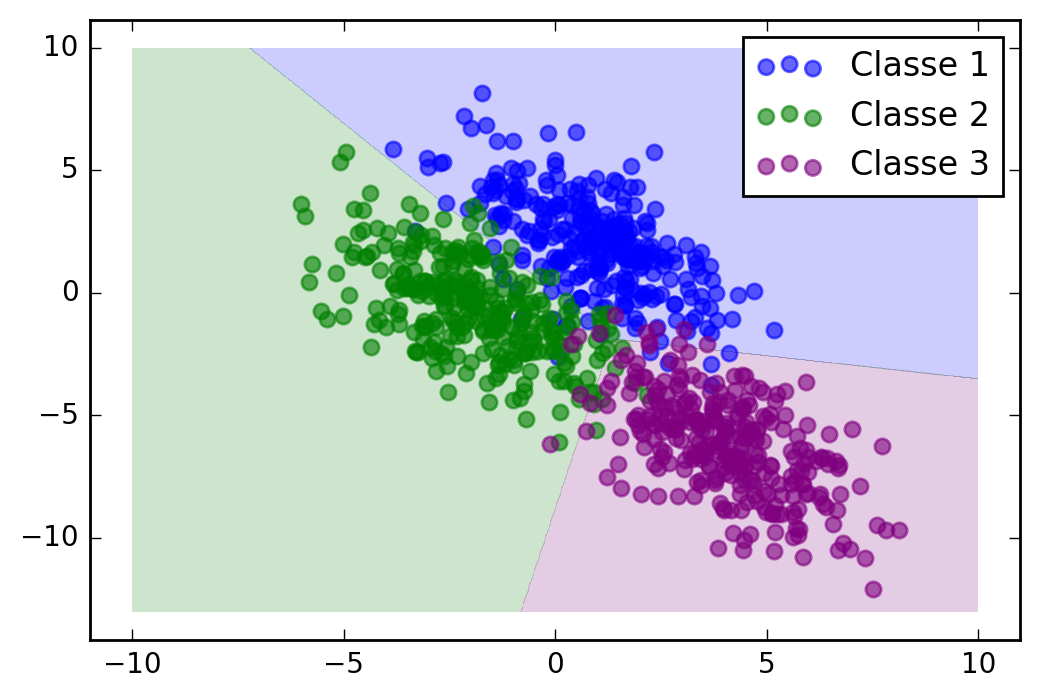

In [15]:
x_min, x_max =-10,10
y_min, y_max = -13, 10

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))        
Z = clf2D2.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0, 1, 2, 3], 
             colors=("blue", "green", "purple"), alpha=.2)
plt.scatter(xx1[:,0],xx1[:,1], marker='o', s=30, 
            color='blue', alpha=0.6, label="Classe 1")
plt.scatter(xx2[:,0],xx2[:,1], s=30, 
            color='green', alpha=0.6, label="Classe 2")
plt.scatter(xx3[:,0],xx3[:,1], s=30, 
            color='purple', alpha=0.6, label="Classe 3")
plt.legend()
figcaption("Discrimination bayésienne linéaire -- Surface séparatrice et discrimination")

### Un exercice

\begin{exercise} Reprendre les données "taille et poids" du chapitre sur la régression logistique et effectuer une discrimination par LDA. Séparer la base en une base d'apprentissage et de test de manière à évaluer correctement les performances. Donner la matrice de confusion. Tracer les nuages de points et les domaines d'affectation des données. 
\end{exercise}
[taille et poids](R%C3%A9gression_logistique.ipynb#Un-exemple---taille-et-poids)

In [16]:
# Embryon de code avant la discrimination
heights_and_weights = pd.read_csv("01_heights_weights_genders.csv")
#
heights_and_weights['Male'] = heights_and_weights['Gender'].map({
    'Male': 1,
    'Female': 0
})
heights_and_weights['H (cm)'] = heights_and_weights['Height'].apply(
    lambda x: x * 2.54)
heights_and_weights['W (kg)'] = heights_and_weights['Weight'].apply(
    lambda x: x / 2.205)
#
features = heights_and_weights[['H (cm)', 'W (kg)']]
target = heights_and_weights['Gender']

### Pourquoi l'analyse discriminante ?

Alors que la logistique régression semble bien fonctionner. Pour les raisons suivantes : 
- lorsque les classes sont bien séparées, les estimées des paramètres de la régression logistique sont instables
- lorsque $N$ n'est pas très grand et les prédicteurs gaussiens, la LDA est également plus stable. 

### Mais au fait, et la régression logistique ?

Supposons que l'on ait que deux classes. Si on fait le rapport entre les deux probabililités 
$$
\Lambda(x) = \frac{\Pr{Y=1|X=x} }{\Pr{Y=0|X=x} } = \frac{f_1(x)}{f_0(x)},
$$
on obtient ce que l'on avait appelé le rapport des chances. Dans le cas gaussien, le logarithme de ce rapport s'écrit tout simplement comme la différence des deux fonctions discriminantes, c'est-à-dire l'expression de la surface de séparation :
$$
\log \Lambda(x) = 
x^T\Gamma^{-1}(\mu_k-\mu_m) - \frac{1}{2}\left(\mu_k^T\Gamma^{-1}\mu_k - \mu_m^T\Gamma^{-1}\mu_m\right)+\log\pi_k-\log\pi_m.
$$
Même si l'expression peut sembler un peu compliquée, il s'agit toutefois d'une fonction linéaire en les composantes de $x$, qui pourrait se mettre sous la forme
$$
\log \Lambda(x) = \beta_0 + \sum_{i=1}^p \beta_i x_i,
$$
soit **exactement la forme que nous avions adopté pour la *régression logistique* **! So what. Tout ça pour rien ? Non bien sûr, il y a coincidence des relations dans le cas gaussien avec même matrice de covariance, mais le rationnel des deux méthodes est très différent. La régression logistique ne fait pas d'hypothèse sur les lois elles même mais uniquement sur la forme du rapport de vraisemblance. En un sens elle est moins contrainte, plus modulable. Même si les équations sont similaires dans le cas gaussien, le calcul  des solutions n'est pas identique. Comme on l'a vu, il passe par un algorithme du gradient pour la régression logistique, et simplement par l'estimation des paramètres de lois dans le cas LDA. D'autre part, la régression logistique n'utilise que la vraisemblance $\Pr{Y|X}$ quand la LDA utilise la vraisemblance complète (incluant la modélisation de $\Pr{X|Y}$). 

## Analyse discriminante quadratique

### Principe

Différentes extensions peuvent être obtenues en relachant des hypothèses.  Notamment, lorsque l'on ne suppose plus que les matrices de covariance sont identiques dans toutes les classes, alors on obtient ce que l'on appelle l'**analyse discriminante quadratique**. 

La fonction discriminante est maintenant
$$
\delta_k(x) =  -\frac{1}{2}(x-\mu_k)^T\Gamma_k^{-1}(x-\mu_k)-\frac{p}{2}\log\text{det}(\Gamma_k) +\log\pi_k.
\label{eq:fonctiondicriminanteQDA}
$$
La surface séparatrice entre les classes $k$ et $m$ devient
$$
\frac{1}{2}(x-\mu_k)^T\Gamma_k^{-1}(x-\mu_k)-\frac{1}{2}(x-\mu_m)^T\Gamma_m^{-1}(x-\mu_m) +\frac{p}{2}\log \frac{\text{det}(\Gamma_k)}{\text{det}(\Gamma_m)}  +\log\frac{\pi_m}{\pi_k}=0.
\label{eq:separatriceQDA}
$$
Il ne s'agit plus d'un hyperplan du fait de la présence du terme quadratique. En dimension 2, il s'agit d'une conique. 

En ce qui concerne l'estimation des paramètres, il faut maintenant estimer la matrice de covariance associée à chaque classe
$$
\hat\Gamma_k = \frac{1}{n_k-1} \sum_{n/ y_n=k} (x_n-\mu_k)(x_n-\mu_k)^T.
$$

### Exemple: mélange de gaussiennes de covariances différentes

Illustrons ceci avec des données bidimensionnelles. Somme de deux gaussiennes, de moyennes et de covariances différentes. Ces données sont générées ci-dessous, en utilisant une méthode du module scipy.stats. On représente ensuite les pdf associées, à la fois en contour et en pseudo-3D. Dès que l'on a des dimensions supérieures, cela devient compliqué, et on doit par exemple projeter sur certains plans, rechercher des composantes plus "représentatives" que d'autres, etc. 

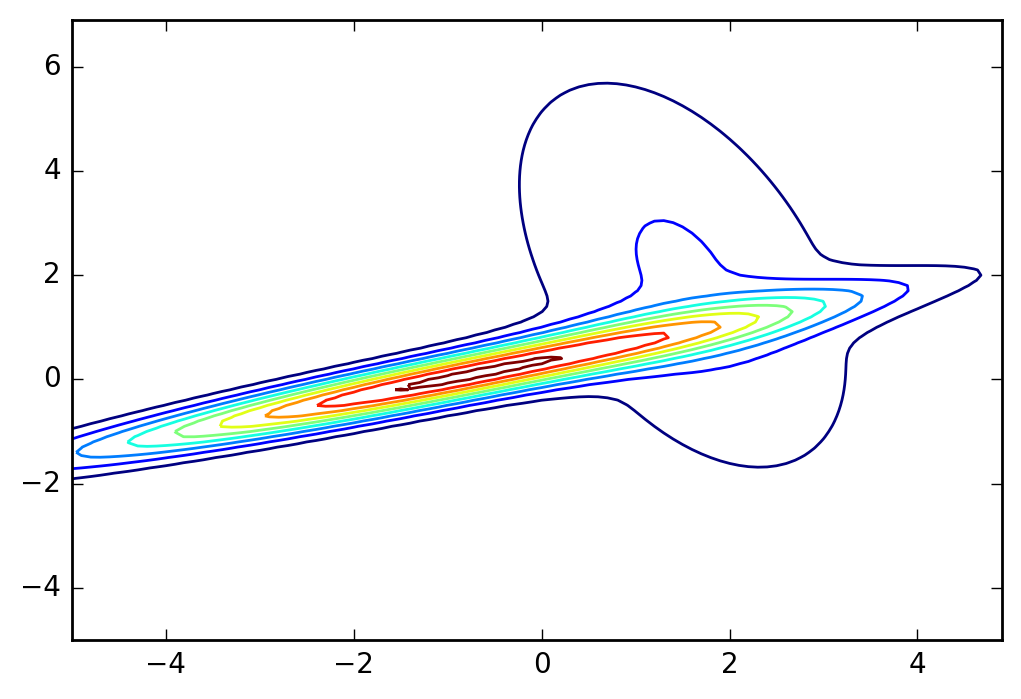

In [17]:
#c1=stats.multivariate_normal(mean=[1.5,2], cov=[[2, -1],[-2, 4]])
c1 = stats.multivariate_normal(mean=[1.5, 2], cov=[[2, -2], [-2, 9]])
#c2=stats.multivariate_normal(mean=[-1,0], cov=[[4, 2],[2, 4]])
c2 = stats.multivariate_normal(mean=[-1, 0], cov=[[7, 1], [2.5, 1]])

# On prépare de quoi la représenter en 3D
x, y = np.mgrid[-5:5:.1, -5:7:.1]
pos = np.empty(x.shape + (2, ))
pos[:, :, 0] = x
pos[:, :, 1] = y

# Avec des contours
%matplotlib inline
#inline
_ = plt.contour(x, y, c1.pdf(pos) + c2.pdf(pos), 10)
figcaption("Mélange de deux gaussiennes 2D de covariances différentes")

Using matplotlib backend: TkAgg


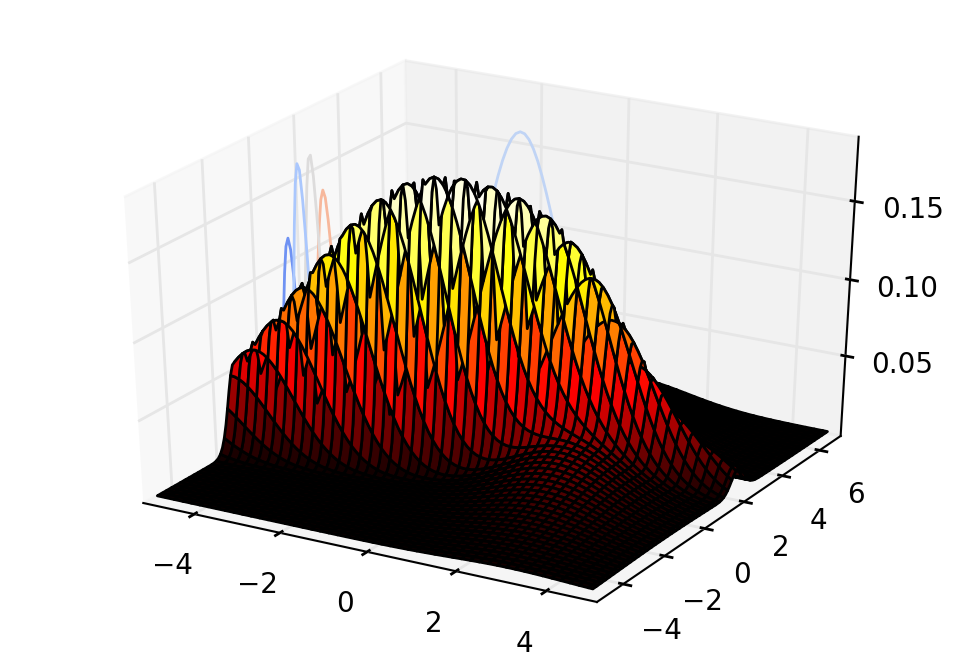

In [18]:
# en 2D et demi -- on invoque %matplotlib pour passer sur un backend graphique externe
# on pourrait également utiliser   plt.switch_backend('TkAgg') 

%matplotlib
mesh(c1.pdf(pos)+c2.pdf(pos),X=x, Y=y, numfig=1)

In [19]:
from sklearn.qda import QDA

# Génération de données 
xx1 = c1.rvs(size=500)
xx2 = c2.rvs(size=500)

X = np.concatenate((xx1, xx2))
y = np.ones(np.shape(X)[0])
y[np.shape(xx1)[0]:] = 2

#y[np.shape(x1)[0]:np.shape(x1)[0]+np.shape(x2)[0]]=2
#y[np.shape(x1)[0]+np.shape(x2)[0]:]=3

# instanciation du classifieur
clf_qda = QDA()
clf_lda = LDA()
# On apprend les choses (fit) sur ces données
clf_qda.fit(X, y)
clf_lda.fit(X, y)

/usr/local/lib/python3.5/site-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

Examinons maintenant quels sont les domaines définis par la méthode.

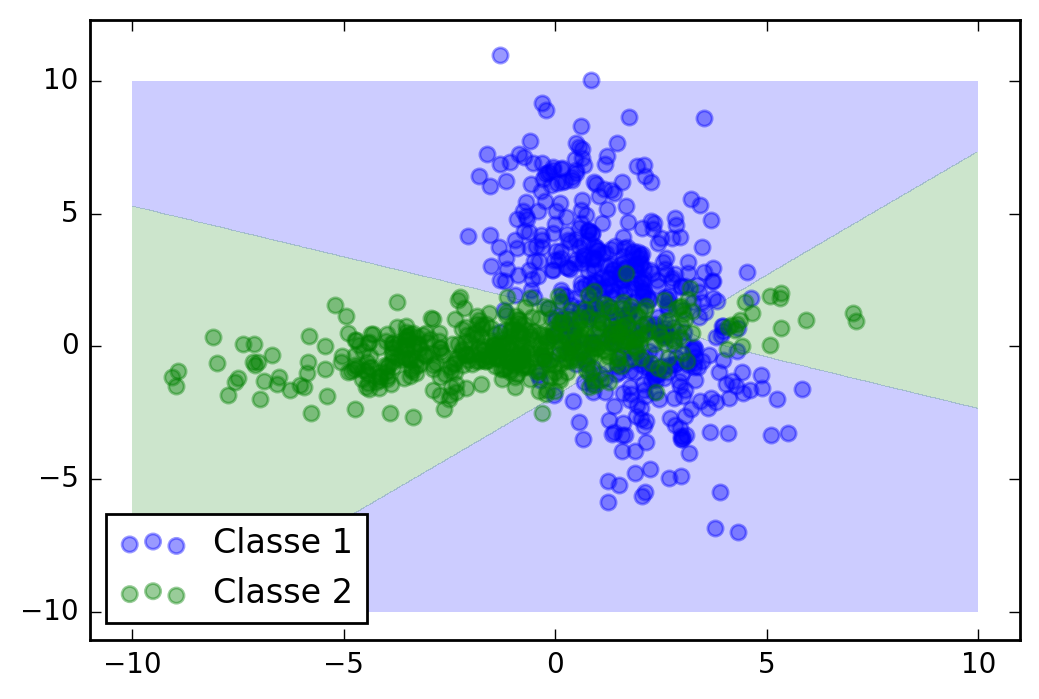

In [20]:
%matplotlib inline
x_min, x_max = -10, 10
y_min, y_max = -10, 10

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf_qda.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(
    xx, yy, Z, levels=[0, 1, 2, 3],
    colors=("blue", "green", "purple"),
    alpha=.2)
plt.scatter(
    xx1[:, 0], xx1[:, 1], marker='o', s=30, color='blue', alpha=0.4,
    label="Classe 1")
plt.scatter(
    xx2[:, 0], xx2[:, 1], s=30, color='green', alpha=0.4, label="Classe 2")
#plt.scatter(x3[:,0],x3[:,1], s=30, color='purple', alpha=0.6, label="Classe 3")
plt.legend(loc='lower left')
figcaption(
    "Discrimination bayésienne quadratique -- Surface séparatrice et discrimination"
)

Zoomons sur la ``surface séparatrice'' : 

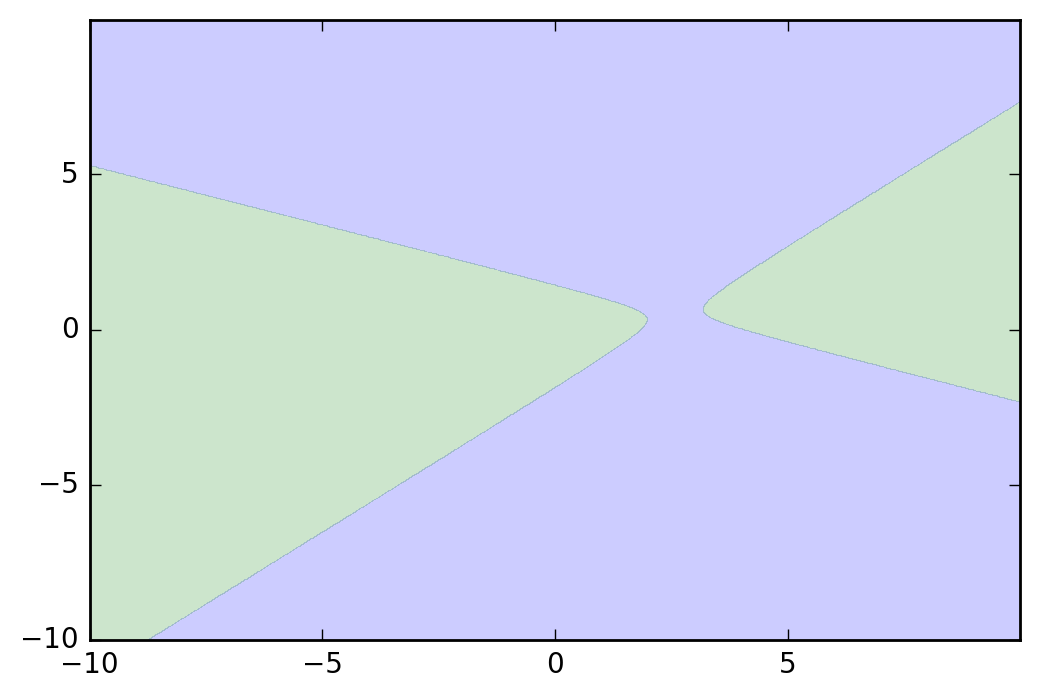

In [21]:
plt.contourf(
    xx, yy, Z, levels=[0, 1, 2, 3],
    colors=("blue", "green", "purple"),
    alpha=.2);

On peut observer que la QDA a été capable d'adapter la surface séparatrice à l'"orientation" des données. Celle-ci est effectivement donnée par le biais de la matrice de covariance qui est prise en compte dans cette version. 

Pour comparaison, regardons la version linéaire. Dans ce cas, la surface séparatrice est un hyperplan, une droite ici. Il semble bien que ce soit moins adapté.

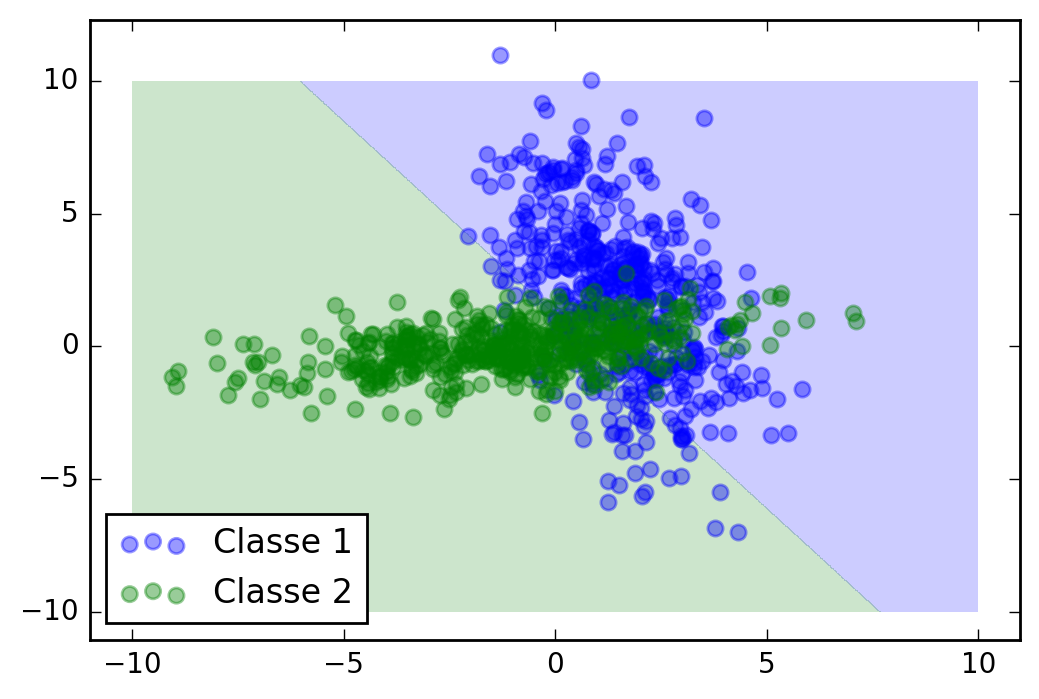

In [22]:
# Pour comparaison la version LDA
plt.figure()
Z = clf_lda.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0, 1, 2, 3], 
             colors=("blue", "green", "purple"), alpha=.2)
plt.scatter(xx1[:,0],xx1[:,1], marker='o', s=30, 
            color='blue', alpha=0.4, label="Classe 1")
plt.scatter(xx2[:,0],xx2[:,1], s=30, color='green', 
            alpha=0.4, label="Classe 2")
#plt.scatter(x3[:,0],x3[:,1], s=30, color='purple', alpha=0.6, label="Classe 3")
plt.legend(loc='lower left')
figcaption("Discrimination bayésienne linéaire -- Surface séparatrice et discrimination")

Les performances des deux méthodes peuvent être évaluées via les matrices de confusion associées, les scores et autres indicateurs (précision, recall). Sur l'exemple présenté, où la LDA ne fait pas un si mauvais job (voire même bon), la QDA permet de gagner entre 5 et 10%. 

In [23]:
from mycfm import *
x1_test = c1.rvs(size=300)
x2_test = c2.rvs(size=300)
X = np.concatenate((x1_test, x2_test))
y_test = np.ones(np.shape(X)[0])
y_test[np.shape(x1_test)[0]::] = 2
#
y_pred = clf_qda.predict(X)
print("Résultats pour la QDA")
print(mycfm(y_test, y_pred))
#
y_pred = clf_lda.predict(X)
print("*" * 40)
print("Résultats pour la LDA")
print(mycfm(y_test, y_pred))

Résultats pour la QDA
Predicted  1.0  2.0  All
True                    
1.0        264   36  300
2.0         51  249  300
All        315  285  600

Score          0.855
Precision      0.874
Recall         0.83
None
****************************************
Résultats pour la LDA
Predicted  1.0  2.0  All
True                    
1.0        249   51  300
2.0         92  208  300
All        341  259  600

Score          0.762
Precision      0.803
Recall         0.693
None


### Expression des probas d'appartenance aux différentes classes

On se souvient que ce que l'on cherchait au départ, c'est à établir les probabilités  $\Pr{Y=k|X=x}$ données par (\ref{eq:bayesrule2}), qui est reproduite ci-dessous pour éviter de remonter tout le texte :
$$
\Pr{Y=k|X=x} = \frac{ \pi_k f_k(x) }{\sum_{l=1}^L \pi_l f_l(x)}.
$$
Dans les deux cas gaussiens, -- LDA et QDA, nous avons vu que les choses se simplifient et qu'il faut simplement évaluer la fonction discriminante $\delta_k(x)=\log \Pr{X=x|Y=k} + \text{cste}$. Aussi, pour revenir aux probabilités, il est possible de simplement utiliser les différentes $\delta_k(x)$, prendre l'exponentielle et normaliser :
$$
\Pr{Y=k|X=x} = \frac{ \pi_k e^{\delta_k(x)} }{\sum_{l=1}^L \pi_l e^{\delta_l(x)}}.
$$
C'est ce qui est fait en pratique dans les implantations, et cela évite de trainer des probabilités, qui sont souvent très faibles (cela entraîne des problèmes numériques), dans les algoritmes. 

## Naive Bayes

### Principe

Une autre méthode est dite naïve et appelée *naive Bayes* (terminologie anglo-saxonne). De quoi s'agit-il ? Lorsque le nombre de variables explicatives devient grand, par exemple $p=2000$, les méthodes précédentes vont nous amener à estimer et manipuler (inverser notamment) des matrices de taille $p\times p $. Ce n'est pas forcément raisonnable, et en plus c'est souvent instable. 

L'idée du Bayes naïf est d'introduire une hypothèse d'*indépendance des différentes variables*. C'est pratiquement toujours faux, voire très faux. Il y a une dépendance entre le poids et la taille, entre le nombre de pièces, la taille des pièces, et la surface d'un appartement ;  etc. 

Dans le cas Gaussien, cela revient à supposer que les matrices de covariance sont diagonales. Dans le cas général, l'hypothèse d'indépendance signifie que $P(Y=k|X=x)$ notre recherche ultime, s'écrit comme 
$$
\Pr{Y=k|X=x}  \propto { \pi_k f_k(x) } = \pi_k \Pi_{j=1}^p f_{kj}(x_j) 
$$
où les $x_j$ sont les composantes du vecteur $x$ de dimension $p$. Pour ce qui est des fonctions de discrimation, on obtient alors 
$$
\delta_k(x) = \log(\pi_k)+ \sum_{j=1}^p \log\left(f_{kj}(x_j)\right). 
$$
Il faut noter que du fait de l'hypothèse d'indépendance, toutes les variables agissent pour leur compte, séparément. Notamment, il n'y a plus aucune interaction entre les variables (produits croisés). À noter également que dans l'expression ci-dessus, la *forme* de $f_{kj}$ n'est pas spécifiée. On pourra avoir plusieurs variantes suivant la spécification de cette loi (notamment, on recontrera du binomial, multinomial et du gaussien -- la sélection dépend de ce qu'on a dans les $x_j$). 

En dépit de la grosse simplification opérée (et qui est nécessaire si $p$ est grand), la discrimination par Bayes naïf fonctionne généralement bien ; par contre les probabilités associées pour les affectations ne sont pas très bonnes. En d'autres termes, il y a du biais dû aux simplifications, mais les probabilités, même biaisées, ont tendance à rester ordonnées seon les classes.

### Exemple 1 - mélange de gaussiennes

À titre de premier exemple, et pour montrer comment utiliser les fonctions de la bibliothèque `sklearn` (c'est très facile maintenant qu'on a pris le pli), on reprend l'exemple du mélange gaussien. Les amplitudes des variables explicatives sont gaussiennes et par conséquent on prendra un Bayes naïf gaussien. 

In [24]:
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()

On regénère les données qui nous intéressent. 

In [25]:
# Génération de données 
xx1 = c1.rvs(size=500)
xx2 = c2.rvs(size=500)

X = np.concatenate((xx1, xx2))
y = np.ones(np.shape(X)[0])
y[np.shape(xx1)[0]:] = 2

Puis on applique la stratégie habituelle. 

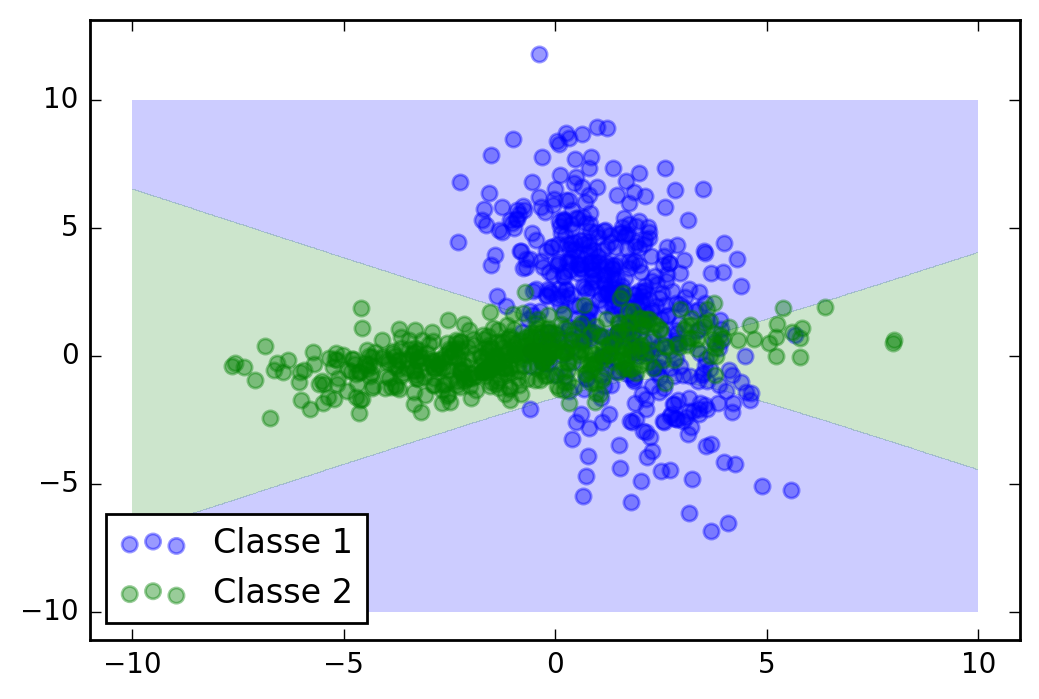

In [26]:
# fit
clf_gnb.fit(X,y)

# Et représentation
%matplotlib inline
x_min, x_max = -10,10
y_min, y_max = -10,10

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))        
Z = clf_gnb.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0, 1, 2, 3], colors=("blue", "green", "purple"), alpha=.2)
plt.scatter(xx1[:,0],xx1[:,1], marker='o', s=30, color='blue', alpha=0.4, label="Classe 1")
plt.scatter(xx2[:,0],xx2[:,1], s=30, color='green', alpha=0.4, label="Classe 2")
#plt.scatter(x3[:,0],x3[:,1], s=30, color='purple', alpha=0.6, label="Classe 3")
plt.legend(loc='lower left')
figcaption("Bayes naïf gaussien -- Surface séparatrice et discrimination")

Performances

In [27]:
from mycfm import *
x1_test = c1.rvs(size=300)
x2_test = c2.rvs(size=300)
X = np.concatenate((x1_test, x2_test))
y_test = np.ones(np.shape(X)[0])
y_test[np.shape(x1_test)[0]::] = 2
#
y_pred = clf_gnb.predict(X)
print("*" * 40)
print("Résultats pour Bayes naïf gaussien")
print(mycfm(y_test, y_pred))

****************************************
Résultats pour Bayes naïf gaussien
Predicted  1.0  2.0  All
True                    
1.0        232   68  300
2.0         31  269  300
All        263  337  600

Score          0.835
Precision      0.798
Recall         0.897
None


On constate que le Bayes naïf est mieux adapté à ce problème que la LDA. Comme il estime des variances différentes pour chacune des classes, la fonction de discrination comporte un terme quadratique qui permet de définir des frontières plus souples qu'une simple droite; Toutefois l'absence de terme d'interaction (covariance) fait perdre un peu en score. **Sur cet exemple particulier** on obtient la hiérarchie suivante : QDA > Bayes naïf > LDA. 

### Exemple 2 - Discrimination de digits binaires

Pour terminer, on considère un problème de discrimination de l'écriture manuscrite (chiffres). 

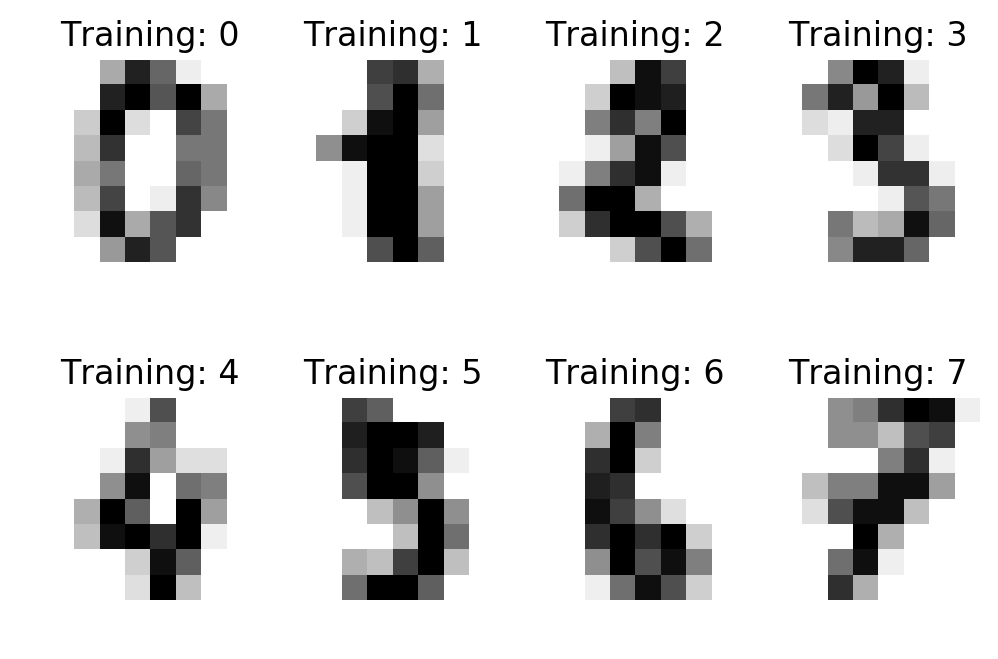

In [28]:
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# minor modifs: jfb
# License: Simplified BSD

# Standard scientific Python imports
import pylab as pl

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits,
# let's have a look at the first 3 images, stored in the `images`
# attribute of the dataset. If we were working from image files, we
# could load them using pylab.imread. For these images know which
# digit they represent: it is given in the 'target' of the dataset.
for index, (image, label) in enumerate(zip(digits.images, digits.target)):
    if index>7: break
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=pl.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [29]:
# Create a classifier: a support vector classifier
classifier = GaussianNB()

# We learn the digits on the first half of the digits
classifier.fit(data[:n_samples / 2], digits.target[:n_samples / 2])

# Now predict the value of the digit on the second half:
expected = digits.target[n_samples / 2:]
predicted = classifier.predict(data[n_samples / 2:])

print("Classification report for classifier %s:\n%s\n" %
      (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier GaussianNB():
             precision    recall  f1-score   support

          0       0.98      0.95      0.97        88
          1       0.81      0.74      0.77        91
          2       0.87      0.84      0.85        86
          3       0.88      0.79      0.83        91
          4       1.00      0.73      0.84        92
          5       0.70      0.81      0.76        91
          6       0.96      0.99      0.97        91
          7       0.65      0.81      0.72        89
          8       0.61      0.76      0.68        88
          9       0.77      0.66      0.71        92

avg / total       0.82      0.81      0.81       899


Confusion matrix:
[[84  0  0  0  0  2  0  0  1  1]
 [ 0 67  2  0  0  0  0  2 13  7]
 [ 0  8 72  0  0  1  2  0  3  0]
 [ 0  2  2 72  0  2  0  2  9  2]
 [ 1  0  0  0 67  0  0 22  1  1]
 [ 0  2  0  4  0 74  1  3  2  5]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  2  0  0 12  0 72  2  1]
 [ 0  2  5  0  0  9  0  4 6

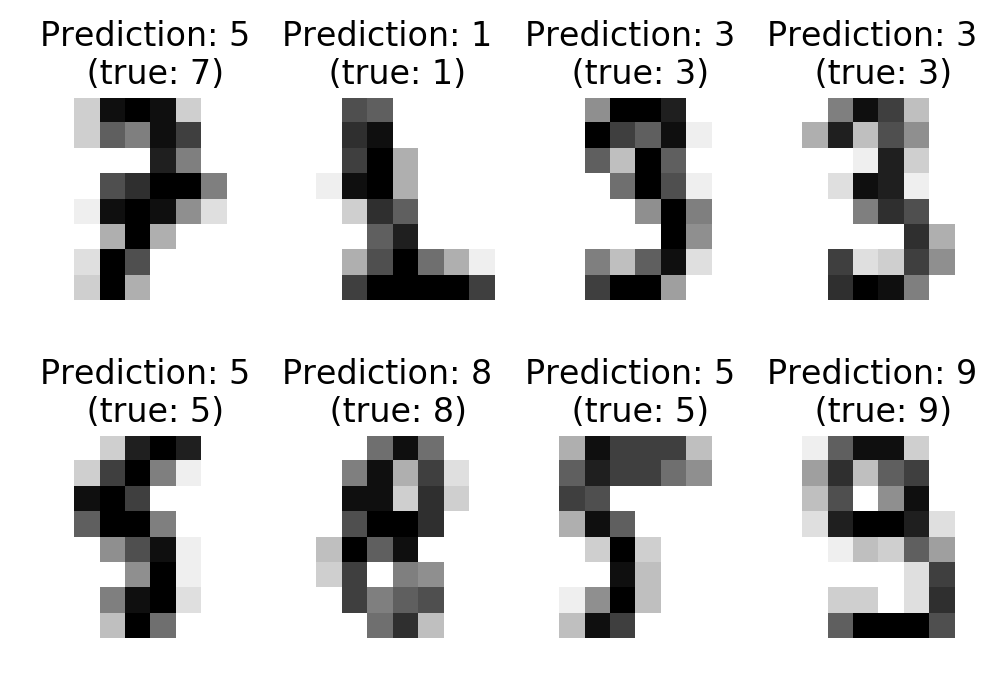

In [30]:
#take 8 examples at random (jfb)
I = np.random.choice(int(n_samples / 2), size=8, replace=False)
data_test = data[n_samples / 2:][I]
data_test_target = digits.target[n_samples / 2:][I]

for index, (image, label) in enumerate(zip(data_test, data_test_target)):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(8, 8), cmap=pl.cm.gray_r, 
               interpolation='nearest')
    plt.title('Prediction: {0} \n (true: {1})'.format(
        int(classifier.predict(image.reshape(1, -1))), label))